In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def oscilator(d,wo,x):
    assert d<wo
    w=np.sqrt(wo**2-x**2)
    phi=np.arctan(-d/w)
    A=1/(2*np.cos(phi))
    cos=torch.cos(phi+w*x)
    sin=torch.sin(phi+w*x)
    exp=torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [4]:
d,wo=2,20
x=torch.linspace(0,1,500).view(-1,1)

In [5]:
y=oscilator(d,wo,x).view(-1,1)

In [6]:
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


torch.Size([10, 1]) torch.Size([10, 1])


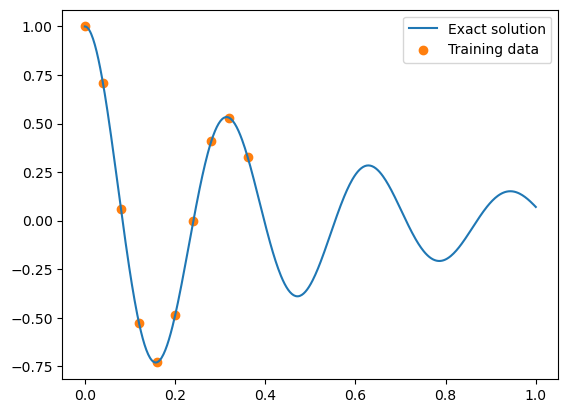

In [8]:
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [17]:
class FCN(nn.Module):
    " Defined a connected network"
    
    def __init__(self,N_INPUT,N_OUTPUT,N_HIDDEN,N_LAYERS):
        super().__init__()
        activation=nn.Tanh
        self.fcs=nn.Sequential(*[nn.Linear(N_INPUT,N_HIDDEN),activation()]) 
        self.fch=nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN,N_HIDDEN),activation()]) 
                                 for _ in range(N_LAYERS-1)])
        self.fce=nn.Linear(N_HIDDEN,N_OUTPUT)
    def forward(self,x):
        x=self.fcs(x)
        x=self.fch(x)
        x=self.fce(x)
        return x
                              

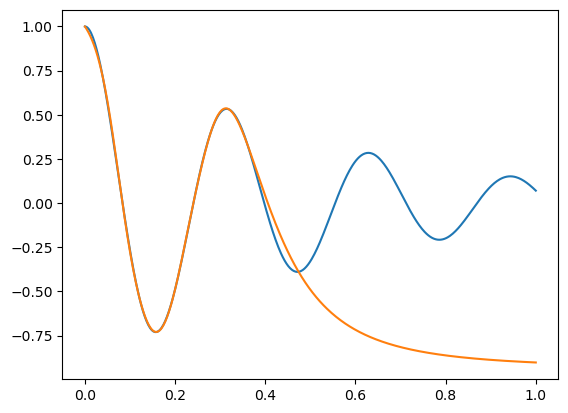

In [61]:
torch.manual_seed(123)
model_TradNN=FCN(1,1,32,3)
optimizer=torch.optim.Adam(model_TradNN.parameters(),lr=1e-3)
for i in range(20000):
    optimizer.zero_grad()
    yh=model_TradNN(x_data)
    loss =torch.mean((yh-y_data)**2)
    loss.backward()
    optimizer.step()
##    if (i+1) %1000 ==0:
##        print(i)
#       yh=  model_TradNN(x).detach()
        
#        plt.plot(x,y)
#        plt.plot(x,yh)
        
x1=torch.linspace(0,1,500).view(-1,1)  
yh1=model_TradNN(x1).detach()
y1=oscilator(d,wo,x1).view(-1,1)
plt.plot(x,y)
plt.plot(x1,yh1)

In [ ]:
#PINN

In [64]:
x_physics=torch.linspace(0,1,30).view(-1,1).requires_grad_(True)
mu,k=2*d,wo**2
torch.manual_seed(123)
model_PINN=FCN(1,1,32,3)
optimizer=torch.optim.Adam(model_PINN.parameters(),lr=1e-4)
for i in range(20000):
    optimizer.zero_grad()
    yh=model_PINN(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model_PINN(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()

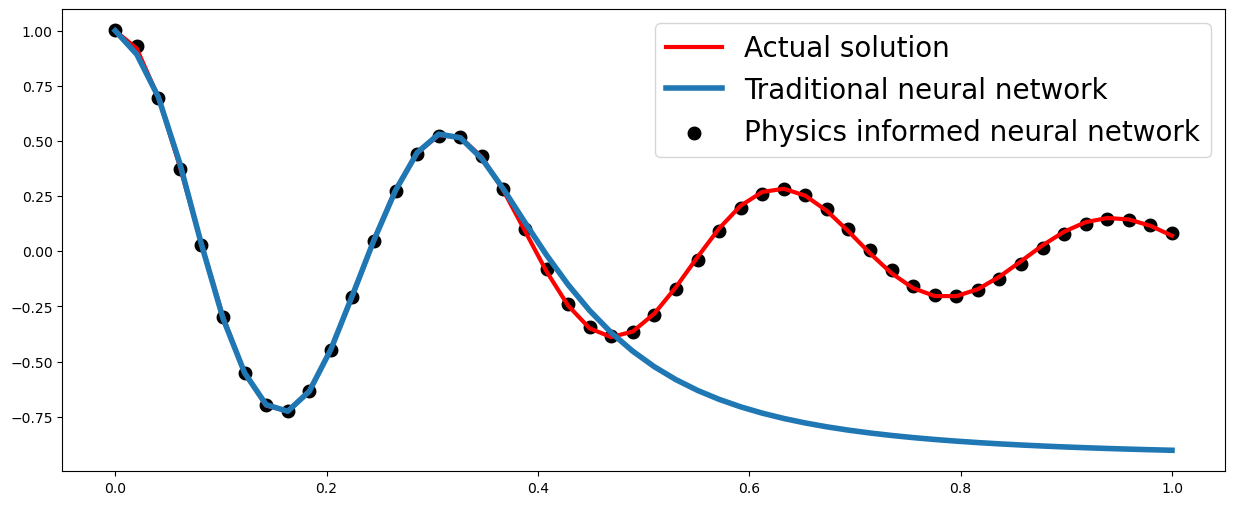

In [97]:
plt.figure(figsize=(15,6))
x1=torch.linspace(0,1,50).view(-1,1)  
yh_tradNN=model_TradNN(x1).detach()
yh_PiNN=model_PINN(x1).detach()
y1=oscilator(d,wo,x1).view(-1,1)
plt.plot(x1,y1,label='Actual solution',color='red',linewidth=3)
plt.plot(x1,yh_tradNN,label='Traditional neural network',linewidth=4)
plt.scatter(x1,yh_PiNN,label='Physics informed neural network',linewidth=4,color='black')
plt.legend(prop={'size': 20})